# Linear Regression with Maps


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import linregress as lr

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

#### Read in my ESPI index

In [2]:
file_espi='/homes/jcampb8/data-shell/thesis/espi_1979-2019.nc'
ds_espi=xr.open_dataset(file_espi)
ds_espi

<xarray.Dataset>
Dimensions:  (time: 492)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
Data variables:
    espi     (time) float64 ...

In [3]:
ds_espi=ds_espi.sel(time=slice('1982-01-01','2018-12-01'))
ds_espi

<xarray.Dataset>
Dimensions:  (time: 444)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
Data variables:
    espi     (time) float64 -0.565 -0.648 -0.285 -0.457 ... 0.395 0.281 0.292

#### Read in my CMAP precipitation data

In [4]:
file='/homes/jcampb8/data-shell/thesis/enso4_1979-2018.cmap.monthly.precip.mon.mean.nc'
ds_precip=xr.open_dataset(file)
ds_precip

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 480)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Conventions:    COARDS
    title:          CPC Merged Analysis of Precipitation (excludes NCEP Reana...
    platform:       Analyses
    source:         ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    dataset_title:  CPC Merged Analysis of Precipitation
    documentation:  https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References:     https://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    date_modified:  26 Feb 2019
    version:        V1912
    history:        update 12/2019 V1912
    data_modified:  2019-12-12

In [5]:
ds_precip=ds_precip.sel(time=slice(ds_espi['time'][0],ds_espi['time'][-1]))

#### Get Anomalies

In [6]:
ds_climo=ds_precip.groupby('time.month').mean()
ds_anoms=ds_precip.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36, time: 444)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2018-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    precip   (time, lat, lon) float32 -0.119510144 -0.16511825 ... 0.4263096

#### Reshape data to get m,r, and p statistical values, run a loop

In [7]:
nx=len(ds_anoms['lon'])
ny=len(ds_anoms['lat'])

p_array=np.zeros((ny,nx))
r_array=np.zeros((ny,nx))
m_array=np.zeros((ny,nx))

for i in range(nx):
    for j in range(ny):
        
        x=ds_espi['espi']
        y=ds_anoms['precip'][:,j,i]
        
        m,b,r,p,e = lr(x,y)
        
        m_array[j,i]=m
        r_array[j,i]=r
        p_array[j,i]=p


In [8]:
m_array

array([[-0.01403853,  0.01430899,  0.02193751, ..., -0.05162354,
         0.01516681,  0.03224393],
       [-0.00113109,  0.05779932,  0.03799111, ..., -0.03922753,
         0.01140803,  0.01069118],
       [-0.0186972 ,  0.11995598,  0.05762615, ..., -0.02197183,
         0.00654246,  0.03052776],
       ...,
       [ 1.06990483,  0.86696271,  0.87182558, ..., -0.28215514,
        -0.28327407, -0.37815888],
       [ 0.89150043,  0.76435216,  0.69799159, ..., -0.20103593,
        -0.22329157, -0.43882909],
       [ 0.80892087,  0.73868784,  0.6743606 , ..., -0.16754011,
        -0.06585069, -0.15079578]])

In [9]:
r_array

array([[-0.02995427,  0.03586651,  0.05638186, ..., -0.07752064,
         0.06698847,  0.1147221 ],
       [-0.00234221,  0.10896301,  0.08624927, ..., -0.05528863,
         0.05389125,  0.03701596],
       [-0.02733067,  0.1195477 ,  0.07117969, ..., -0.03405079,
         0.02580322,  0.07147253],
       ...,
       [ 0.49522732,  0.45168883,  0.44695502, ..., -0.14675393,
        -0.15576564, -0.19513306],
       [ 0.40796607,  0.37305432,  0.35102868, ..., -0.14853522,
        -0.13752824, -0.20056443],
       [ 0.35160049,  0.34674272,  0.3258703 , ..., -0.13690633,
        -0.0332807 , -0.11366329]])

#### Calculate a mask to calculate where correlation is more than 95% (p=0.05)

In [10]:
mask_sig=np.where(p_array<0.05,m_array,np.nan)

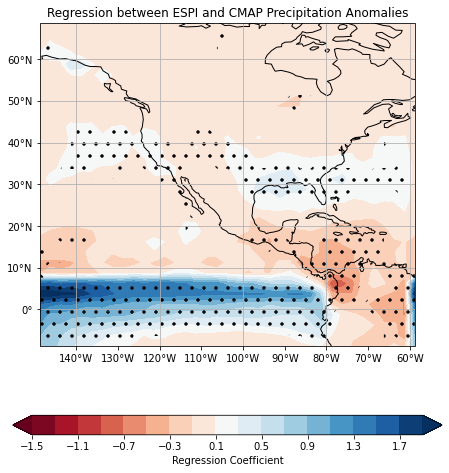

In [11]:

clevs=np.arange(-1.5,2,0.2)

fig = plt.figure(figsize=(11,8.5))

# Set the axes using the specified map projection
ax=plt.axes(projection=ccrs.PlateCarree(central_longitude=180))

# Add cyclic point
data=m_array
data,lon=add_cyclic_point(data,coord=ds_anoms['lon'])
mask_data,lons=add_cyclic_point(mask_sig,coord=ds_anoms['lon'])

# Make a filled contour plot
cs=ax.contourf(lon,ds_anoms['lat'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='RdBu',extend='both')

ax.contourf(lon,ds_anoms['lat'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['.'],extend='both',alpha=0)

# Add coastlines
ax.coastlines()

# Add gridlines
ax.gridlines()

# Define the xticks for longtitude 
ax.set_xticks(np.arange(220,310,10),crs=ccrs.PlateCarree())
lon_formatter=cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define ytick for latitude
ax.set_yticks(np.arange(0,70,10),crs=ccrs.PlateCarree())
lat_formatter=cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

# Call colorbar
cbar=plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient')

# Add title
plt.title('Regression between ESPI and CMAP Precipitation Anomalies')
plt.savefig('Regression-ESPI,Precip')

In [12]:
ds_m=xr.DataArray(m_array,
                  coords={'lat':ds_anoms['lat'],
                          'lon': ds_anoms['lon']},
                  dims=['lat','lon'])        
ds_m=ds_m.to_dataset(name='slope')
ds_m

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
Data variables:
    slope    (lat, lon) float64 -0.01404 0.01431 0.02194 ... -0.06585 -0.1508

In [13]:
ds_p=xr.DataArray(p_array,
                  coords={'lat':ds_anoms['lat'],
                          'lon': ds_anoms['lon']},
                          dims=['lat','lon'])        
ds_p=ds_p.to_dataset(name='pvalue')
ds_p

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
Data variables:
    pvalue   (lat, lon) float64 0.529 0.4509 0.2358 ... 0.003849 0.4842 0.01657

In [14]:
ds_r=xr.DataArray(r_array,
                  coords={'lat':ds_anoms['lat'],
                          'lon': ds_anoms['lon']},
                          dims=['lat','lon'])        
ds_r=ds_r.to_dataset(name='rvalue')
ds_r

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
Data variables:
    rvalue   (lat, lon) float64 -0.02995 0.03587 0.05638 ... -0.03328 -0.1137

In [15]:
ds_regr=xr.merge([ds_m,ds_p,ds_r])
ds_regr
#ds.rename({}) to rename datasets
#Can't merge same-named datasets

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
Data variables:
    slope    (lat, lon) float64 -0.01404 0.01431 0.02194 ... -0.06585 -0.1508
    pvalue   (lat, lon) float64 0.529 0.4509 0.2358 ... 0.003849 0.4842 0.01657
    rvalue   (lat, lon) float64 -0.02995 0.03587 0.05638 ... -0.03328 -0.1137

In [16]:
ds_regr.to_netcdf('regression2.nc')

In [17]:
ds_test=xr.open_dataset('regression2.nc')
ds_test

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 36)
Coordinates:
  * lat      (lat) float32 68.75 66.25 63.75 61.25 ... -1.25 -3.75 -6.25 -8.75
  * lon      (lon) float32 211.25 213.75 216.25 218.75 ... 293.75 296.25 298.75
Data variables:
    slope    (lat, lon) float64 ...
    pvalue   (lat, lon) float64 ...
    rvalue   (lat, lon) float64 ...

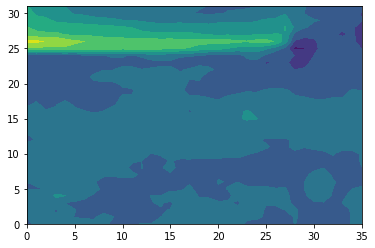

In [18]:
plt.contourf(ds_test['slope'])